# Uplift modeling introduction with example
Stephen Klosterman

In [1]:
# load packages
import numpy as np
import pandas as pd

from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
# from statsmodels.stats.power import TTestIndPower

import sklearn as sk
from sklearn.metrics import auc
import xgboost as xgb

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

- [Intro](#Intro)
    - [What is it?](#What-is-it?)
    - [Why do it?](#Why-do-it?)
    - [Connections to A/B testing](#Connections)
    - [Why does it matter at Tala?](#Why-does-it-matter)
- [Example dataset](#Example)
- [Analyze experimental results](#Analyze)
- [Build a simple uplift model using a transformed target](#Build)
    - [Train XGBoost](#Train)
- [Model evaluation](#Model-evaluation)
    - [Uplift decile chart](#decile-chart)
    - [Cumulative uplift decile chart](#Cumulative-uplift)
    - [Cumulative gain chart](#Cumulative-gain)
    - [Cumulative gain curve (modified Qini curve)](#gain-curve)
    - [Area under the gain curve](#area-under)
    - [Cost benefit analysis](#cost-benefit)
- [Other modeling approaches](#Other)
    - [Multivariate testing](#Multivariate)
- [Feature selection](#Feature)

# Intro <a class="anchor" id="Intro"></a>
### What is it? <a class="anchor" id="What-is-it?"></a>
Uplift modeling is a predictive modeling approach to identifying which customers are most likely to respond to a promotion. This modeling technique goes by several names, including net lift and incremental response modeling.

### Why do it? <a class="anchor" id="Why-do-it?"></a>
Uplift modeling is useful when considering an action, perhaps with a cost, that affects customers in hopes of deriving some benefit. In marketing, this is often characterized as a coupon that might be offered. The coupon has a cost in the form of the lost revenue, due to the offered discount. However, if the offer convinces certain customers to make the purchase, who otherwise wouldn't have, it may be worth it. __Identifying these incremental customers is the goal of uplift modeling.__

In general customers can be broken into four groups, in terms of their behavior when receiving a promotion or not. If the promotion is called a "treatment" and the desired behavior is a purchase, the situation can be visualized like this:

<img src="https://storage.googleapis.com/wf-blogs-engineering-media/2018/10/e45e2d97-confmatrix_alt.png" alt="Drawing" style="width: 400px;"/>

[Yi and Frost, 2018](https://tech.wayfair.com/data-science/2018/10/pylift-a-fast-python-package-for-uplift-modeling)

Uplift modeling seeks to identify the "persuadables" and avoid bothering the "sleeping dogs", or those who would react negatively to the action, if they exist.

### Connections to A/B testing <a class="anchor" id="Connections"></a>
Building an uplift model requires a specific type of data: data from a randomized experiment, often called an A/B test if only one treatment is considered.

>Estimating customer uplift is both a Causal Inference and a Machine Learning problem. It is a causal inference problem because one needs to estimate the difference between two outcomes that are mutually exclusive for an individual (either person *i* receives a promotional e-mail or does not receive it). To overcome this counter-factual nature, uplift modeling crucially relies on randomized experiments, i.e. the random assignment of customers to either receive the treatment (the treatment group) or not (the control group). Uplift modeling is also a machine learning problem as one needs to train different models and select the one that yields the most reliable uplift prediction according to some performance metrics. This requires sensible cross-validation strategies along with potential feature engineering.

[Gutierrez and Gerardy, 2016](http://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf)

The results of an A/B test, such as offering a promotion, should indicate that the action has the desired effect, such as increasing sales. Once this has been established, an uplift model can be built to make a data-driven decision of __which customers to take the action on__, as opposed to taking a potentially costly action on customers at random.

### Why does it matter at Tala? <a class="anchor" id="Why-does-it-matter"></a>
Potential use cases include any costly offer or intervention, expected to increase revenue in some way, or actions that may not have a cost, but nonetheless may have an undesirable sleeping dog effect.
- Collections outreaches
    - Phone calls: have a cost to Tala, in the form of call center operations. The desired benefit is that more customers will repay their loans, as a result of receiving a collections phone call.
    - Digital channels
- Lifecycle messaging
    - Little treatment expense but may deter customers
- Other marketing campaigns
    - Classic use case of uplift modeling

# Example dataset <a class="anchor" id="Example"></a>
These data come from a Starbucks data challenge, communicated via a Nanodegree in data science from Udacity, and then via a [blog post](https://medium.com/datadriveninvestor/simple-machine-learning-techniques-to-improve-your-marketing-strategy-demystifying-uplift-models-dc4fb3f927a2)

- `ID` = customer ID
- `Promotion` = Yes or No, did the customer receive a promotion
- `purchase` = 1 or 0, did the customer make a purchase
- `V1` - `V7` = features

The goal is to create a model to maximize incremental profit from selectively offering the promotion, which has a cost. There are specific goals laid out in the data challenge but here I will use evaluation metrics from a publication: http://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf

In [2]:
# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
ID           84534 non-null int64
Promotion    84534 non-null object
purchase     84534 non-null int64
V1           84534 non-null int64
V2           84534 non-null float64
V3           84534 non-null float64
V4           84534 non-null int64
V5           84534 non-null int64
V6           84534 non-null int64
V7           84534 non-null int64
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


In [4]:
# # Unused here, but in a real project this would be used after model development was essentially done.
# test_data = pd.read_csv('./Test.csv')
# test_data.head()

In [5]:
# test_data.info()

# Analyze experimental results <a class="anchor" id="Analyze"></a>

What was the overall purchase rate?

In [6]:
train_data['purchase'].mean()

0.012302742091939338

How many people were in the experiment group, versus the control group? What was the difference in purchase rate between these groups? 

In [7]:
exp_results_df = \
train_data.groupby('Promotion').agg({'ID':'count',
                                     'purchase':'mean'})
exp_results_df

,ID,purchase
Promotion,,
No,42170,0.007565
Yes,42364,0.017019


In [8]:
exp_results_df.loc['Yes', 'purchase'] - exp_results_df.loc['No', 'purchase']

0.009454547819772702

The sample size in the treatment and control groups is about equal.

The purchase rate in the treatment group is higher than that of the control group. Is the sample size of the experiment large enough to conclude this with statistical significance?

These kinds of questions would typically be part of the experimental design: in an *a priori* statistical power analysis the desired effect size would be decided, along with power and significance level, which would define the necessary sample size. But here we can ask them after the fact (i.e. do a *post hoc* power analysis). If we want statistical power of 0.8 and a significance level of 0.05, what is the sample size we'd need, to conclude that the effect size we found is statistically significant?

In [9]:
cohens_h_effect_size = \
proportion_effectsize(exp_results_df.loc['Yes', 'purchase'], exp_results_df.loc['No', 'purchase'], method='normal')
cohens_h_effect_size

0.0874911783085573

In [10]:
NormalIndPower().solve_power(effect_size=cohens_h_effect_size,
                             nobs1=None,
                             alpha=0.05,
                             power=0.8,
                             ratio=1.0,
                             alternative='two-sided')

2050.728065552541

We have more than this many observations in the treatment group, so we can conclude that the treatment has a statistically significant effect, for the effect size that was found.

Now we can use uplift modeling to try and identify portion of the population who might have a larger effect, as opposed to offering the expensive promotion at random.

# Build a simple uplift model using a transformed target <a class="anchor" id="Build"></a>
There are many approaches to creating uplift models. Perhaps the most intuitive is to create two separate binary classification models, one for the treatment group and one for the control group. The target variable in both models is whether or not a purchase was made. Then the "uplift score" would be the difference in scores between these two models: how much more likely is a customer to make the purchase, if they receive a promotion?

Because it's a bit simpler, here I'll train a single model, using a transformed target variable. All observations are lumped together and the target variable = 1 if the customer received the promotion and made the purchase, otherwise = 0.

In [11]:
#Suggested in blog post
train_data['target'] = train_data['Promotion'].str.match('Yes') & train_data['purchase'].astype('bool')

#Different encoding, suggested in Gutierrez and Gerardy, but doesn't work very well with these data
# train_data['target'] = (train_data['Promotion'].str.match('Yes') & train_data['purchase'].astype('bool'))\
#     | (train_data['Promotion'].str.match('No') & train_data['purchase']==0)

train_data['target'] = train_data['target'].astype('bool')

In [12]:
train_data['target'].value_counts()
# False    83813
# True       721

False    83813
True       721
Name: target, dtype: int64

In [13]:
train_data['target'].sum()
# 721

721

Make a training/validation split.

In [14]:
# split training data into train and validation
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)

Examine class balance of transformed variable in training data.

In [15]:
train['target'].value_counts()
# False    67047
# True       580

False    67047
True       580
Name: target, dtype: int64

There are very imbalanced classes, so we need to downsample training data for balanced classes. A more sophisticated alternative would be to use SMOTE.

https://stackoverflow.com/questions/44114463/stratified-sampling-in-pandas

In [16]:
downsampled_train = \
train.groupby('target', group_keys=False).apply(lambda x: x.sample(train['target'].sum(), random_state=1))

In [17]:
downsampled_train.shape
# (1160, 11)

(1160, 11)

In [18]:
type(downsampled_train)

pandas.core.frame.DataFrame

In [19]:
downsampled_train['target'].value_counts()
# True     580
# False    580

True     580
False    580
Name: target, dtype: int64

Classes are now balanced. The validation data will not be downsampled.

### Train XGBoost <a class="anchor" id="Train"></a>

In [20]:
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

In [21]:
X_train_downsamp = downsampled_train[features]
y_train_downsamp = downsampled_train['target']
X_valid = valid[features]
y_valid = valid['target']

In [22]:
eval_set = [(X_train_downsamp, y_train_downsamp), (X_valid, y_valid)]

Normally a hyperparameter search would be done, but these values used in the blog post work well enough for illustrative purposes.

In [23]:
# Train an xgboost model
model = xgb.XGBClassifier(learning_rate = 0.1,
                          max_depth = 7,
                          min_child_weight = 5,
                          objective = 'binary:logistic',
                          seed = 42,
                          gamma = 0.1,
                          silent = True,
                          n_jobs=2)

In [24]:
%%time
model.fit(X_train_downsamp, y_train_downsamp, eval_set=eval_set,\
          eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.740039	validation_1-auc:0.609996
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.751833	validation_1-auc:0.625492
[2]	validation_0-auc:0.756189	validation_1-auc:0.629561
[3]	validation_0-auc:0.758218	validation_1-auc:0.629651
[4]	validation_0-auc:0.764927	validation_1-auc:0.631139
[5]	validation_0-auc:0.771283	validation_1-auc:0.632887
[6]	validation_0-auc:0.773246	validation_1-auc:0.635403
[7]	validation_0-auc:0.774764	validation_1-auc:0.638418
[8]	validation_0-auc:0.775724	validation_1-auc:0.638948
[9]	validation_0-auc:0.780788	validation_1-auc:0.638842
[10]	validation_0-auc:0.783239	validation_1-auc:0.638794
[11]	validation_0-auc:0.788429	validation_1-auc:0.642171
[12]	validation_0-auc:0.789997	validation_1-auc:0.641225
[13]	validation_0-auc:0.793078	validation_1-auc:0.639637
[14]	validation_0-auc:0.795525	validation_1-auc:0.64065

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=2,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, verbosity=1)

# Model evaluation <a class="anchor" id="Model-evaluation"></a>
Given an uplift model, how do we know how good it is? There are many ways to answer this. First we'll do some basic checks that the model scores are stratifying customers according to how receptive they are to the promotion. These diagnostics are related to an area-under-the-curve type of statistic that can be used to compare models. For uplift models there is something called a Qini curve, which is analogous to an ROC curve for binary classification.

All evaluations are done using the (unbalanced) validation set, and in a real project would eventually be done on the test set.

For equations and detailed descriptions of these evaluations, see "4.1. Traditional Uplift Metrics" in [Gutierrez and Gerardy, 2016](http://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf).

### Uplift decile chart <a class="anchor" id="decile-chart"></a>

Gutierrez and and Gerardy 2016:

>A common approach to evaluate an uplift model is to first predict uplift for both treated and control observations and compute the average prediction per decile in both groups. Then, the difference between those averages is taken for each decile. This difference thus gives an idea of the uplift gain per decile.

Breaking this procedure down in to chunks, first,

> predict uplift for both treated and control observations

Do this for the validation set.

Get uplift prediction for all observations and examine the score distribution:

In [25]:
valid_predict_proba = model.predict_proba(X_valid)[:,1]

Text(0, 0.5, 'Number of observations in validation set')

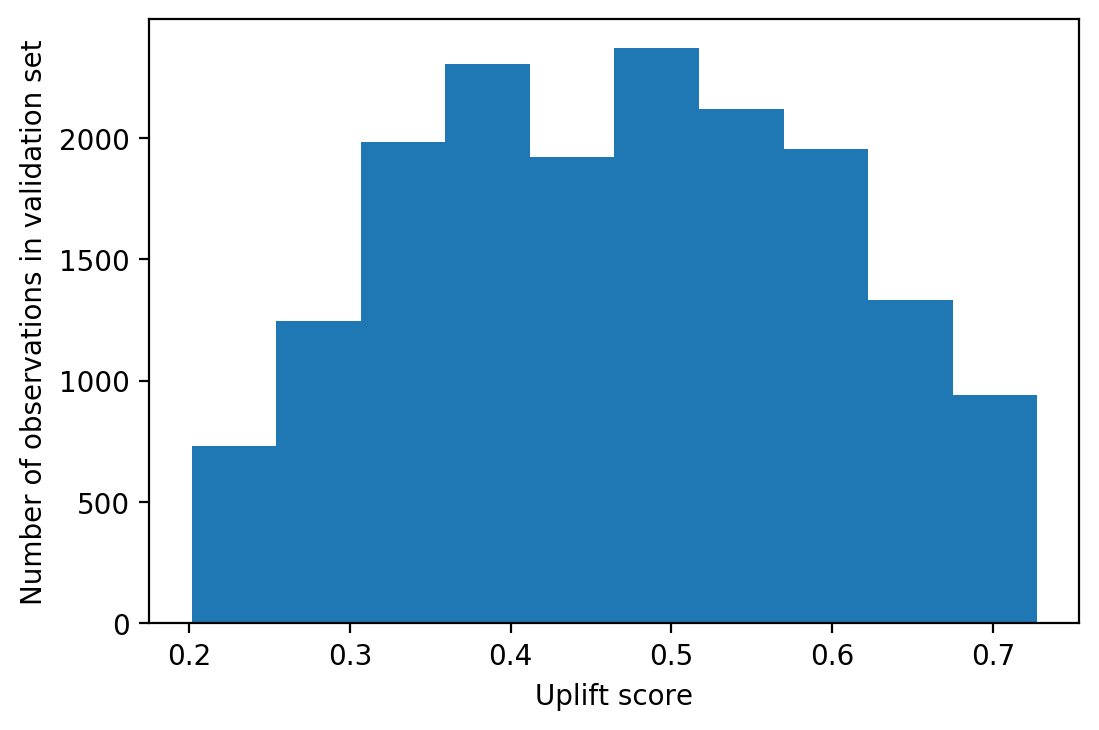

In [26]:
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['figure.figsize'] = (6,4)
plt.hist(valid_predict_proba)
plt.xlabel('Uplift score')
plt.ylabel('Number of observations in validation set')

> compute the average prediction per decile in both groups

I think this may be a typo in the paper, as this would be characterizing the scores within difference deciles of scores, notwithstanding the success of the campaign (`purchase`). To evaluate the relationship between model scores and customer behavior, it seems better to "compute the purchase rate, per decile of model score, in both groups."

In [27]:
valid_predict_proba.shape

(16907,)

In [28]:
valid.shape

(16907, 11)

Create a new dataframe from the validation df, to add the uplift scores and deciles to.

In [29]:
# valid_w_score = test_data.copy()
valid_w_score = valid.copy()
valid_w_score['Uplift score'] = valid_predict_proba

In [30]:
valid_w_score.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,target,Uplift score
6264,9346,Yes,0,3,18.012754,-1.511395,2,2,4,1,False,0.557656
41822,62172,No,0,2,28.676557,-0.126150,2,3,3,2,False,0.618133
8569,12768,No,0,0,28.817748,-1.511395,2,4,3,2,False,0.501890
41228,61264,No,0,1,26.140783,-0.905350,2,1,4,2,False,0.523865
24896,37024,Yes,0,1,32.346423,0.566472,1,2,3,1,False,0.413907


Check that the treatment and control groups are balanced, overall, for the validation set.

In [31]:
valid_w_score['Promotion'].value_counts()
# No     8474
# Yes    8433

No     8474
Yes    8433
Name: Promotion, dtype: int64

Make a Boolean mask that can be used to identify who received the promotion.

In [32]:
validation_treatment_mask = valid_w_score['Promotion'].str.match('Yes')

Make labels for the uplift score deciles. Do treatment and control groups together. We'll check that the treatment and control groups are balanced within the deciles.

In [33]:
decile_labels = [number for number in range(1,11)]
print(decile_labels)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


Pandas has a convenient function to produce a series of labels according to which quantile an observation in the input series belongs to.

In [34]:
score_deciles, score_decile_bins = \
pd.qcut(x=valid_w_score['Uplift score'],
        q=10,
        labels=decile_labels,
        retbins=True)

Here are the quantile labels (not differentiable between treatment and control in this output):

In [35]:
score_deciles.head()

6264     8
41822    9
8569     6
41228    7
24896    4
Name: Uplift score, dtype: category
Categories (10, int64): [1 < 2 < 3 < 4 ... 7 < 8 < 9 < 10]

Bin edges:

In [36]:
score_decile_bins

array([0.20156759, 0.29423583, 0.34919083, 0.38772139, 0.42448917,
       0.47045654, 0.50582469, 0.55224079, 0.59514534, 0.64335269,
       0.72758454])

Check that the number of treated and control observations within decile bins are similar.

In [37]:
valid_w_score['Decile bin'] = score_deciles

In [38]:
valid_w_score.groupby(['Decile bin', 'Promotion'])['Promotion'].count()

Decile bin  Promotion
1           No           882
            Yes          811
2           No           837
            Yes          853
3           No           859
            Yes          847
4           No           830
            Yes          873
5           No           866
            Yes          796
6           No           853
            Yes          840
7           No           835
            Yes          869
8           No           827
            Yes          859
9           No           880
            Yes          810
10          No           805
            Yes          875
Name: Promotion, dtype: int64

These indeed look very similar. This is expected, as we are working with data from a randomized experiment. Examine the top of the dataframe:

In [39]:
valid_w_score[['Promotion', 'Decile bin', 'Uplift score', 'purchase']].head(10)

,Promotion,Decile bin,Uplift score,purchase
6264,Yes,8,0.557656,0
41822,No,9,0.618133,0
8569,No,6,0.501890,0
41228,No,7,0.523865,0
24896,Yes,4,0.413907,0
45830,Yes,3,0.356000,0
61302,Yes,3,0.386093,0
60120,Yes,10,0.661588,0
75899,No,6,0.500598,0
67557,No,2,0.340484,0


Now do a groupby/mean of the purchase occurrence to get the rate of purchase within each decile. Need to do this separately for treatment and control groups.

In [40]:
mean_response_treatment = valid_w_score[validation_treatment_mask].groupby('Decile bin')['purchase'].mean()
mean_response_control = valid_w_score[~validation_treatment_mask].groupby('Decile bin')['purchase'].mean()

In [41]:
mean_response_treatment

Decile bin
1     0.004932
2     0.005862
3     0.008264
4     0.011455
5     0.021357
6     0.017857
7     0.021864
8     0.015134
9     0.029630
10    0.030857
Name: purchase, dtype: float64

In [42]:
mean_response_control

Decile bin
1     0.010204
2     0.008363
3     0.008149
4     0.009639
5     0.003464
6     0.009379
7     0.009581
8     0.009674
9     0.006818
10    0.003727
Name: purchase, dtype: float64

> the difference between those averages is taken for each decile

Finally calculate the lift by subtracting these.

In [43]:
lift = mean_response_treatment - mean_response_control
lift

Decile bin
1    -0.005272
2    -0.002502
3     0.000115
4     0.001816
5     0.017893
6     0.008478
7     0.012283
8     0.005460
9     0.022811
10    0.027130
Name: purchase, dtype: float64

Text(0.5, 1.0, 'Difference in purchase rate\nbetween uplift score deciles of treatment and control group')

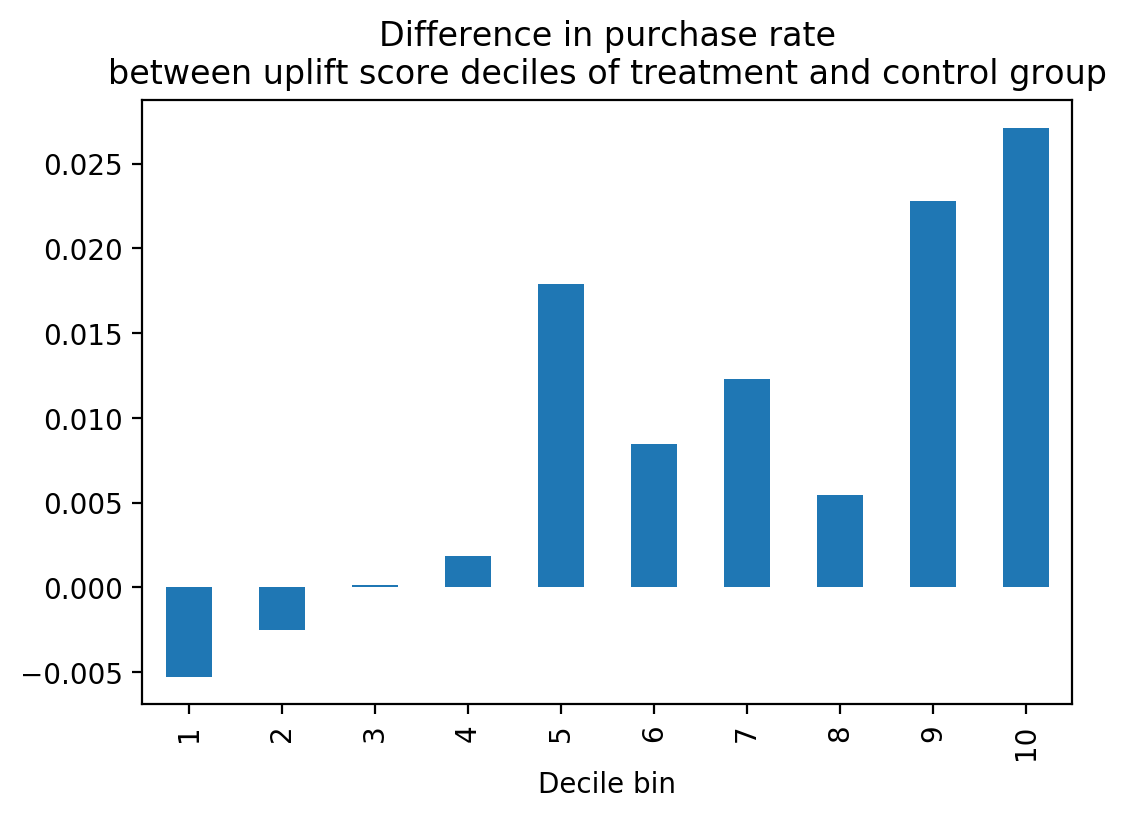

In [44]:
mpl.rcParams['figure.dpi'] = 200
lift.plot.bar()
plt.title('Difference in purchase rate\nbetween uplift score deciles of treatment and control group')

This shows that the model, while not perfect, appears to be useful. Those with lower uplift scores have negative lift. They are actually less likely to purchase, given the promotion. This is the sleeping dog effect. Those with higher scores are more likely to purchase, given the promotion.

These lifts per decile can be compared to the lift expected by giving the promotion to everyone.

In [45]:
purchase_rate_by_promotion = valid.groupby('Promotion')['purchase'].mean()
purchase_rate_by_promotion

Promotion
No     0.007907
Yes    0.016720
Name: purchase, dtype: float64

In [46]:
purchase_rate_by_promotion[1] - purchase_rate_by_promotion[0]

0.00881349081506308

This indicates that if we selectively offer the promotion to those with higher uplift scores, we can expect more of a lift in purchase rates than offering the promotion at random.

In practice, given limited capacity to offer the promotion, we'd target people starting with the highest lift scores and proceeding down. Cumulative decile charts provide a way to visualize the effect of this.

### Cumulative uplift decile chart <a class="anchor" id="Cumulative-uplift"></a>

In [47]:
decile_labels[::-1]

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

This indexing `[::-1]` reverses a list.

Start with the highest decile, calculate the lifts of targeting everyone with scores in that decile or higher.

In [48]:
treatment_mean = []
control_mean = []
treatment_sum = []
control_sum = []
treatment_n = []
control_n = []

for decile_countdown in decile_labels[::-1]:
    decile_list = list(range(decile_countdown,11))
    decile_mask = valid_w_score['Decile bin'].isin(decile_list)
    
    treatment_mean.append(valid_w_score.loc[validation_treatment_mask & decile_mask, 'purchase'].mean())
    control_mean.append(valid_w_score.loc[~validation_treatment_mask & decile_mask, 'purchase'].mean())
    
    treatment_sum.append(valid_w_score.loc[validation_treatment_mask & decile_mask, 'purchase'].sum())
    control_sum.append(valid_w_score.loc[~validation_treatment_mask & decile_mask, 'purchase'].sum())
    
    treatment_n.append(valid_w_score.loc[validation_treatment_mask & decile_mask, 'purchase'].count())
    control_n.append(valid_w_score.loc[~validation_treatment_mask & decile_mask, 'purchase'].count())
    

In [49]:
cumulative_lift = np.array(treatment_mean) - np.array(control_mean)

In [50]:
cumulative_lift_series = pd.Series(data=cumulative_lift, index=decile_labels[::-1], name='Cumulative lift')

In [51]:
cumulative_lift_series

10    0.027130
9     0.024926
8     0.018390
7     0.016849
6     0.015185
5     0.015671
4     0.013645
3     0.011951
2     0.010335
1     0.008813
Name: Cumulative lift, dtype: float64

Check that the final decile gives the expected lift from marketing to everyone:

In [52]:
lift_from_all = \
valid_w_score.loc[validation_treatment_mask, 'purchase'].mean()\
- valid_w_score.loc[~validation_treatment_mask, 'purchase'].mean()

lift_from_all

0.00881349081506308

Yes.

Text(0.5, 0, 'Uplift score decile')

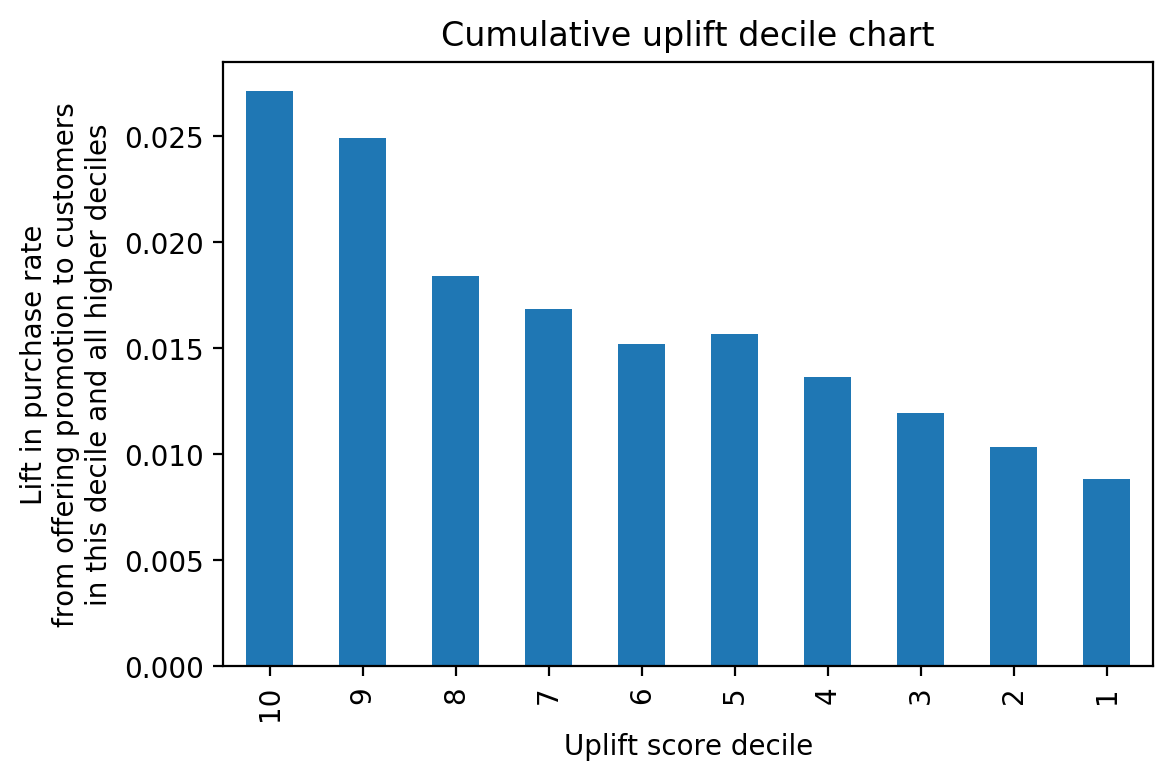

In [53]:
cumulative_lift_series.plot.bar()
plt.title('Cumulative uplift decile chart')
plt.ylabel('Lift in purchase rate\nfrom offering promotion to customers\nin this decile and all higher deciles')
plt.xlabel('Uplift score decile')

### Cumulative gain chart <a class="anchor" id="Cumulative-gain"></a>
This chart analyzes the effect of targeting customers starting with the highest scores and proceeding lower in a cumulative fashion, similar to the cumulative decile chart. Instead of looking at the lift in purchase rate, the interpretation here seems like the number of incremental customers that can be gained by targeting a given proportion of the population.

In [54]:
cumulative_gain = \
((np.array(treatment_sum) / np.array(treatment_n))
 - (np.array(control_sum) / np.array(control_n))) \
* (np.array(treatment_n) + np.array(control_n))

In [55]:
cumulative_gain

array([ 45.57913043,  84.        ,  92.97840804, 113.90198166,
       128.36231584, 158.50801076, 161.25716907, 161.62129121,
       157.23158283, 149.00968921])

Check that the final decile is the lift, in terms of number of people, from marketing to everyone.

In [56]:
lift_from_all * valid_w_score.shape[0]

149.0096892102715

In [57]:
cumulative_gain_series = \
pd.Series(data=cumulative_gain, index=decile_labels[::-1], name='Cumulative gain')

Text(0.5, 0, 'Uplift score decile')

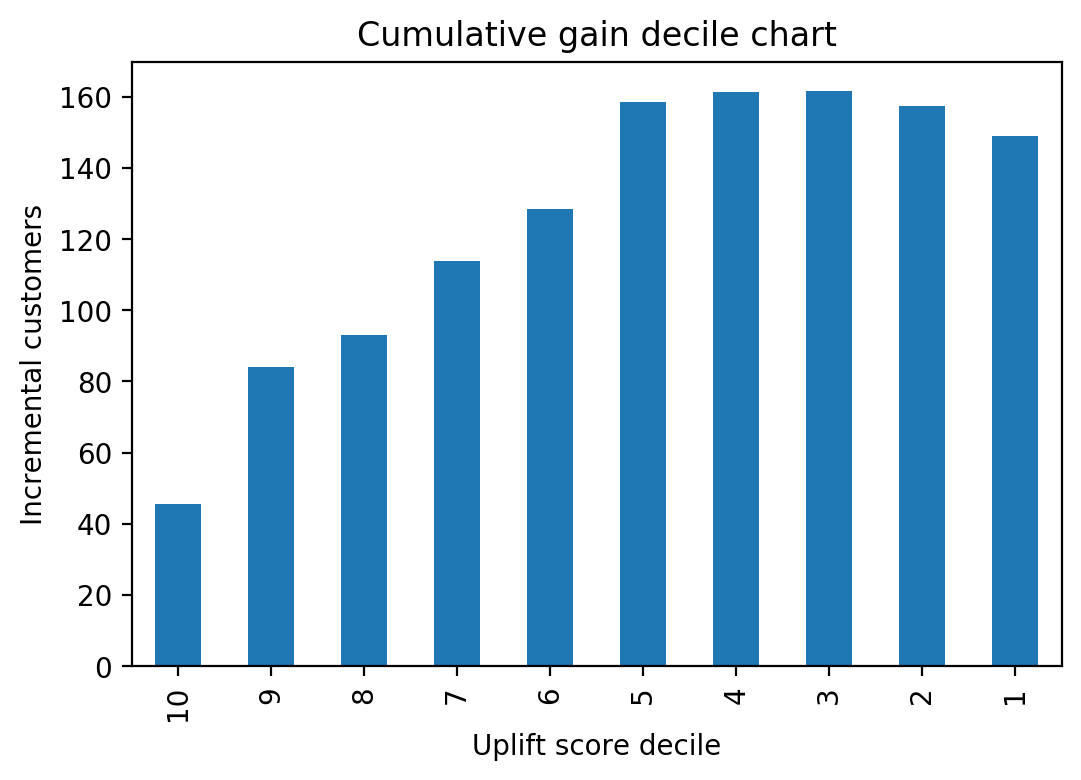

In [58]:
cumulative_gain_series.plot.bar()
plt.title('Cumulative gain decile chart')
plt.ylabel('Incremental customers')
plt.xlabel('Uplift score decile')

The text states that 
>We can thus choose the decile that maximizes the gain as the limit of the population to be targeted

This seems true if finances are not considered. A probably better way to select the limit of the population to be targeted is via a cost/benefit analysis.

### Cumulative gain curve (modified Qini curve) <a class="anchor" id="gain-curve"></a>
This is a more continuous version of the cumulative gain chart. Instead of breaking the population into deciles, here we look at the incremental lift of offering the promotion to the customer with the highest uplift score, then add customers one at a time, in order of descending uplift score. There is a related concept called the Qini curve in the uplift literature, which should be directly proportional to the gain curve, assuming a randomized and balanced experimental design.

In [59]:
sorted_valid = valid_w_score.sort_values('Uplift score', ascending=False)
sorted_valid.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,target,Uplift score,Decile bin
63907,95205,Yes,0,2,29.866117,0.047006,2,3,4,2,False,0.727585,10
36957,54988,Yes,0,1,30.263528,-0.559039,2,3,2,2,False,0.727585,10
19234,28627,Yes,0,2,29.515353,-0.991928,2,3,4,2,False,0.727585,10
74824,111658,No,0,0,30.091188,-0.039572,2,3,1,2,False,0.727585,10
79710,118964,No,0,1,30.346373,-0.732194,2,3,1,1,False,0.727585,10


Check method of counting those who received promotion.

In [60]:
(sorted_valid.iloc[0:4,:]['Promotion'] == 'Yes').sum()

3

In [61]:
sorted_valid.shape

(16907, 13)

Variable names follow notation in Gutierrez and Gerardy.

In [62]:
%%time
y_t = []
y_c = []
n_t = []
n_c = []
gain_curve = []
for row_ix in range(sorted_valid.shape[0]):
    y_t.append(
        ((sorted_valid.iloc[0:row_ix,:]['Promotion'] == 'Yes') &
         (sorted_valid.iloc[0:row_ix,:]['purchase'] == 1)).sum()
    )
    y_c.append(
        ((sorted_valid.iloc[0:row_ix,:]['Promotion'] == 'No') &
         (sorted_valid.iloc[0:row_ix,:]['purchase'] == 1)).sum()
    )
    n_t.append((sorted_valid.iloc[0:row_ix,:]['Promotion'] == 'Yes').sum())
    n_c.append((sorted_valid.iloc[0:row_ix,:]['Promotion'] == 'No').sum())
    
    gain_curve.append( ((y_t[-1]/n_t[-1]) - (y_c[-1]/n_c[-1])) * (n_t[-1] + n_c[-1]) )
    
    if row_ix % 1000 == 0:
        print(row_ix)
#Wall time: 1min 49s at home

/Users/stephen.klosterman/Documents/Virtual_Envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
CPU times: user 1min 30s, sys: 198 ms, total: 1min 30s
Wall time: 1min 30s


Probably a divide by zero error early on.

Plot the gain curve, along with the theoretical gain from offering the promotion at random.

In [63]:
n_customers = np.array(range(len(gain_curve)))
random_promotion = n_customers*lift_from_all

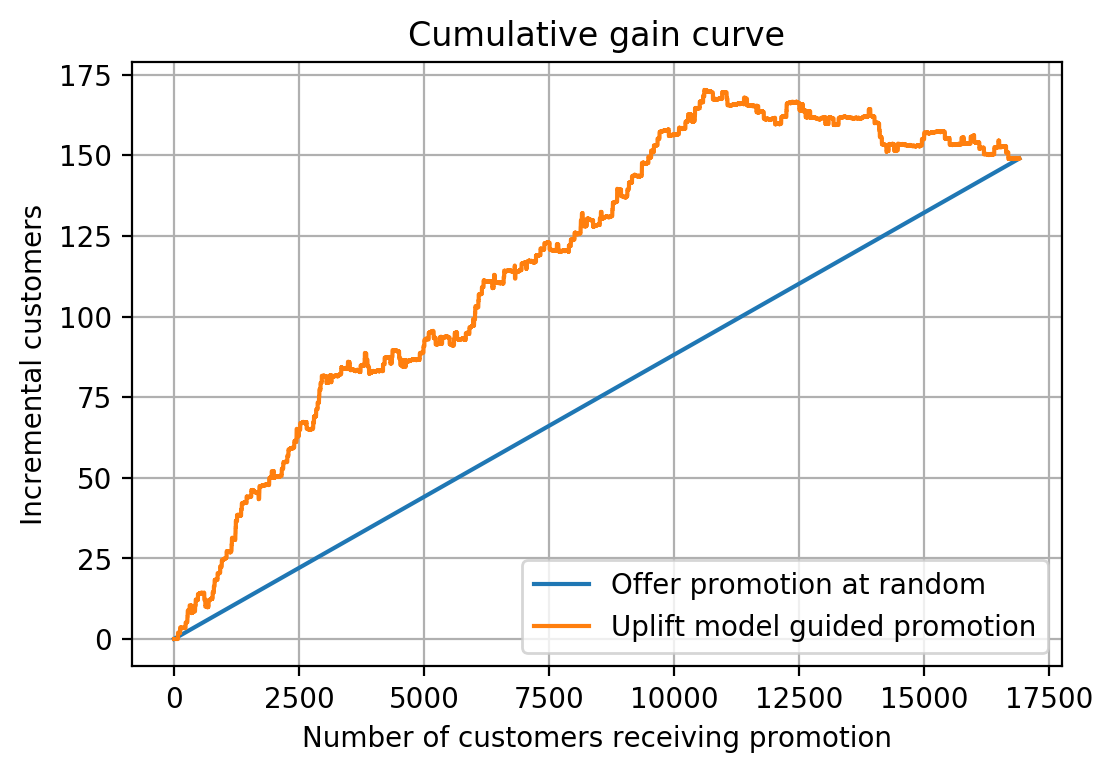

In [64]:
plt.plot(n_customers, random_promotion, label='Offer promotion at random')
plt.plot(n_customers, gain_curve, label='Uplift model guided promotion')
plt.grid()
plt.title('Cumulative gain curve')
plt.ylabel('Incremental customers')
plt.xlabel('Number of customers receiving promotion')
plt.legend()

Neat. All the evidence here points to there not being a particularly strong sleeping dog effect in this data set. If there were, the gain curve would slope down more at the highest number of customers.

This curve, in comparison with the random line, shows how many more incremental customers can be gained from using a model-guided strategy, as opposed to offering the promotion at random.

### Area under the gain curve <a class="anchor" id="area-under"></a>
The area under the gain curve can be calculated from as a general indicator of the performance of an uplift model. Intuitively, it seems like a good uplift model should introduce a large number of incremental customers at the highest uplift scores, and push the sleeping dogs to the lowest scores, effectively sloping the uplift. Models with these characteristics would tend to have larger areas under the gain curve.

This statistic can be compared between different modeling approaches, similar how the area under the ROC curve is commonly used for binary classifiers.

Get rid of the first few NaNs and calculate the AUC.

In [65]:
gain_curve[:8]

[nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0]

In [66]:
auc(x=range(len(gain_curve[4:])), y = gain_curve[4:])

1989093.426401922

This is not necessarily interpretable by itself, as the AUC of the ROC is, but it could be used to compare models.

### Cost benefit analysis <a class="anchor" id="cost-benefit"></a>

A more financially relevant way to determine the effect of the model on business operations is a cost-benefit analysis. This may or may not indicate the same number of customers to send the promotion to, as the financially unaware Qini curve.

A simple way to do this would be to look at the profit (revenue minus cost) of targeting the top n scorers in the validation set. If we assume the revenue of a sale is \\$10 and the cost of offering the promotion is \\$0.25 (note I chose a larger cost than the \\$0.15 in the data challenge because it creates a clearer optimization), we can find the optimal number of people to target by using the results from the gain curve.

Given the variables created above, we can calcuate profit as follows:

In [67]:
revenue = (np.array(y_t) + np.array(y_c)) * 10
cost = np.array(n_t) * 0.25
profit = revenue - cost

Text(0.5, 0, 'Number of customers receiving promotion')

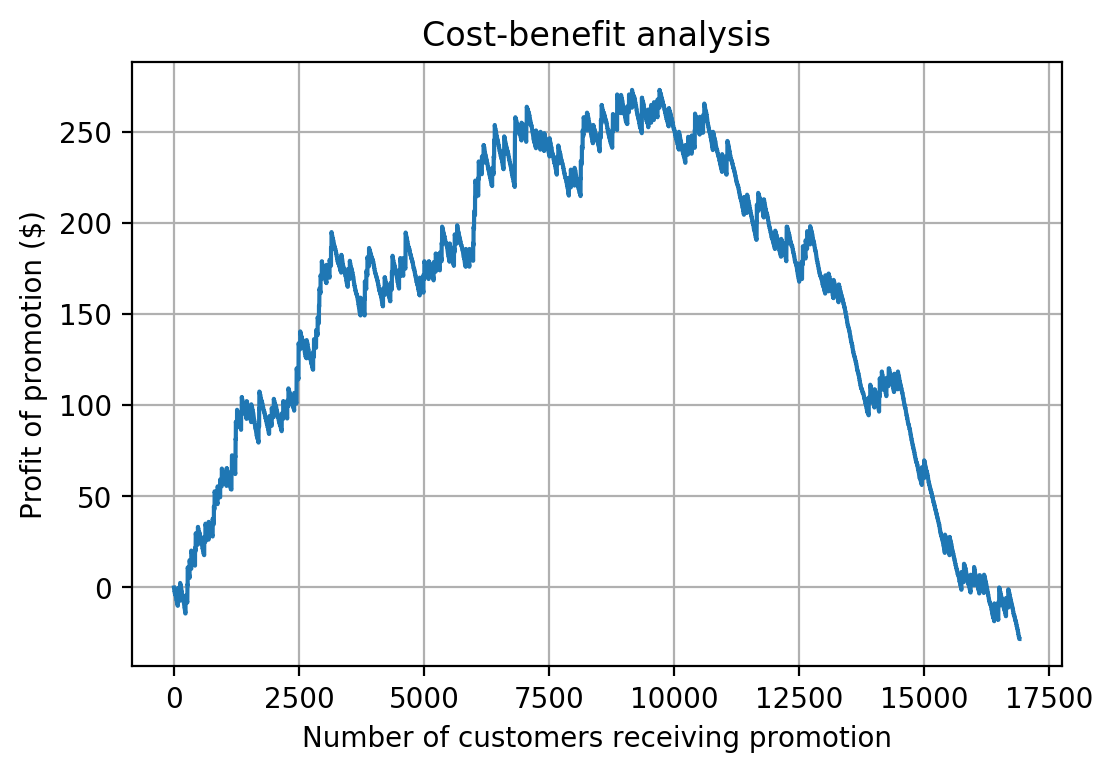

In [68]:
plt.plot(profit)
plt.grid()
plt.title('Cost-benefit analysis')
plt.ylabel('Profit of promotion ($)')
plt.xlabel('Number of customers receiving promotion')

It appears that the procedure of ranking people on their uplift score, then offering promotions to the highest scorers, creates increasing profits up to about 8-9,000 people. Beyond that, the cost of the promotion outweighs the chances of purchase.

# Other modeling approaches <a class="anchor" id="Other"></a>
There are many different methods proposed for uplift modeling. I've started a [Google Drive literature review to organize them here](https://docs.google.com/spreadsheets/d/1V5oyKAR0MF2vyXTZ-J3Qq6lcDSHCz4TJyILCAvd0dME/edit?usp=sharing). That is still in progress; please let me know if there are additional resources to consider there, or if I've gotten anything wrong.

- Two models
    - One for treatment group, one for control group. Scores are differenced for uplift
- One model with treatment variable
    - Scored twice, once with treatment = 1, and once with = 0, and differenced for uplift
- Transformation to binary target, then use binary classification model (illustrated here)
- Transformed outcome in a regression model ([Yi and Frost, 2018](https://tech.wayfair.com/data-science/2018/10/pylift-a-fast-python-package-for-uplift-modeling))
- Multiclass model using a 4 class target (see first image in notebook)
- Tree-growing algorithms with uplift-based splitting criteria ([Gutierrez and Gerardy, 2016](http://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf), [CausalML](https://causalml.readthedocs.io/en/latest/about.html))

### Multivariate testing <a class="anchor" id="Multivariate"></a>
Apparently uplift modeling can be extended to consider multiple treatments ([Gutierrez and Gerardy, 2016](http://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf), [CausalML](https://causalml.readthedocs.io/en/latest/about.html)) and determine the one with the highest uplift. This seems like it would require data from a multivariate experiment.

# Feature selection <a class="anchor" id="Feature"></a>

In this contrived example, we were presented with a small number of explanatory variables and performed no feature selection. In reality, feature selection is an important part of the predictive modeling workflow.

The target encoding used above simplifies the task of feature selection, since the binary classification model (e.g. XGBoost) can be used to rank features in terms of feature importance, or mean absolute SHAP value.

When not using an encoding such as this, for example in the two-model approach, a standard method for variable prescreening in uplift modeling builds on the concepts of weight of evidence (WOE) and information value (IV). These concepts have been traditionally used to perform univariate feature selection in the context of binary classification. WOE and IV rely on binning values of predictors, so they present a unified framework to consider continuous and categorial features, as well as capturing linear and non-linear effects and handling missing values.

To extend these concepts to uplift modeling and account for the treatment effect, the techniques of net weight of evidence (NWOE) and net information value (NIV) are used. Some good reads on this can be found [here](https://multithreaded.stitchfix.com/blog/2015/08/13/weight-of-evidence/) and [here](https://support.sas.com/resources/papers/proceedings13/096-2013.pdf).

An opportunity here is to implement NWOE and NIV in Python, possibly as a new package, or as a contribution to another package, as this does not appear to have been done (as it has been in SAS and I think R).

This would enable an independent point of comparison to feature importances or SHAPs from XGBoost above.